## Score, and cross-validated scores

In [19]:
from sklearn import datasets, svm, linear_model
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import numpy as np

In [2]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [3]:
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.98

### Split the data into folds

In [4]:
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)

In [5]:
scores = list()
for k in range(3):
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
    
print(scores)

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


In [6]:
# Using KFold

kf = KFold(n_splits=3)
print("Splits: ", kf.get_n_splits(X_digits))
kf

Splits:  3


KFold(n_splits=3, random_state=None, shuffle=False)

In [7]:
scores = list()
for train_index, test_index in kf.split(X_digits):
    X_train, X_test = X_digits[train_index], X_digits[test_index]
    y_train, y_test = y_digits[train_index], y_digits[test_index]
    
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
    
print(scores)

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


## Cross-validation Generators

In [8]:
cross_val_score(svc, X_digits, y_digits, cv=kf, n_jobs=1)

array([0.93489149, 0.95659432, 0.93989983])

### Exercise: Plot Cross-validation score

In [9]:
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()

In [10]:
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X_digits, y_digits)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

In [11]:
scores

[0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.9026027024733573,
 0.9482070815179453,
 0.9449071473407464,
 0.9437997276286755,
 0.9437997276286755]

In [12]:
scores_std

[0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.003217697307891147,
 0.013615673615136992,
 0.009447937924571914,
 0.010287004922697952,
 0.010287004922697952]

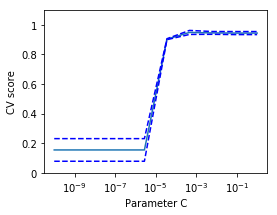

In [14]:
# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

## Grid-search and cross-validated estimators

### Grid-search

In [15]:
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-06, 3.59381e-06, 1.29155e-05, 4.64159e-05, 1.66810e-04,
       5.99484e-04, 2.15443e-03, 7.74264e-03, 2.78256e-02, 1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
clf.best_score_

0.925

In [17]:
clf.best_estimator_.C

0.007742636826811277

In [18]:
clf.score(X_digits[1000:], y_digits[1000:])

0.9435382685069009

### Cross-validated estimators

In [20]:
lasso = linear_model.LassoCV()
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

In [21]:
lasso.fit(X_diabetes, y_diabetes)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [22]:
lasso.alpha_

0.012291895087486173

### Exercise - Find Optimal Regularization Parameter Alpha

In [30]:
alphas = np.logspace(-4, -0.5, 30)
lasso = linear_model.Lasso(random_state=0)
X_train_diabetes = X_diabetes[:150]
y_train_diabetes = y_diabetes[:150]

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

In [31]:
clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_train_diabetes, y_train_diabetes)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

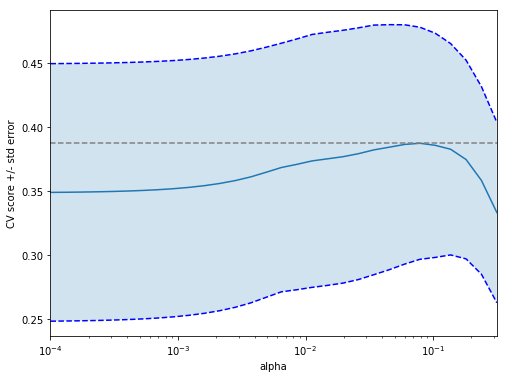

In [32]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])